# **Importing Libraries**

In [6]:
pip install hdbscan

In [7]:
pip install ydata-profiling

In [8]:
!pip install matplotlib

In [9]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
import ydata_profiling as yp
import pandas_profiling

loading data


In [10]:
# Loading the dataset with a different encoding
data1 = pd.read_csv('/content/online(sample).csv', encoding='latin-1')
data1.head()

InvoiceNo StockCode                       Description  Quantity  \
0    555200     71459    HANGING JAM JAR T-LIGHT HOLDER        24   
1    554974     21128                GOLD FISHING GNOME         4   
2    550972     21086       SET/6 RED SPOTTY PAPER CUPS         4   
3    576652     22812  PACK 3 BOXES CHRISTMAS PANETTONE         3   
4    546157     22180                    RETROSPOT LAMP         2   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01/06/2011 12:05       0.85     17315.0  United Kingdom  
1  27/05/2011 17:14       6.95     14031.0  United Kingdom  
2  21/04/2011 17:05       0.65     14031.0  United Kingdom  
3  16/11/2011 10:39       1.95     17198.0  United Kingdom  
4  10/03/2011 08:40       9.95     13502.0  United Kingdom

# **EDA ANALYSIS?????**

# **Data Preprocessing**


Data preprocessing is a broader concept that includes data cleaning and other steps to prepare the data for machine learning algorithms. These steps may include data transformation, feature selection, normalization, and reduction. The goal of data preprocessing is to convert raw data into a suitable format that machine learning algorithms can learn.

## Data Cleaning

In [11]:
len(data1)

15000

In [12]:
# drop duplicates
data1 = data1.drop_duplicates(subset=None, keep='first', ignore_index=True)

In [13]:
len(data1)

14997

In [14]:
#To remove the NA values
data = data1.dropna()
print("The total number of data after  missing values drop:", len(data))

The total number of data after  missing values drop: 11176


In [15]:
data.describe()

Quantity     UnitPrice    CustomerID
count  11176.000000  11176.000000  11176.000000
mean      12.165265      3.150592  15260.126432
std       49.583260     18.476025   1711.732626
min    -1350.000000      0.000000  12347.000000
25%        2.000000      1.250000  13924.000000
50%        5.000000      1.950000  15078.500000
75%       12.000000      3.750000  16764.000000
max     2880.000000   1867.860000  18287.000000

**if i am trying to do segmentation and i have negative quantity,during my reprocessing I need to check this as it could be refunds and willnt be need in my classification**


In [16]:
# Filtering out rows with negative quantities
data = data[data['Quantity'] >= 0]

# Checking the updated dataset
print("The total number of data after removing negative quantities:", len(data))

The total number of data after removing negative quantities: 10926


In [17]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## **Feature Engineering**

### Recency, Frequency, Monetary (RFM) Analysis:

Calculating recency allows businesses to understand the current engagement level of their customers. Customers who have made purchases or interacted with the business more recently are often considered more engaged and potentially more valuable. Recency is a crucial metric in customer segmentation and retention strategies, as it helps identify active customers who may require different marketing approaches compared to less engaged ones.

In [18]:
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d/%m/%Y %H:%M')

In [19]:
# Calculate recency: Determine how recently each customer made a purchase.

# Calculate the latest date in the dataset
latest_date = data['InvoiceDate'].max()

# Calculate recency for each customer
data['Recency'] = latest_date - data.groupby('CustomerID')['InvoiceDate'].transform('max')

# Convert recency to days
data['Recency'] = data['Recency'].dt.days

data.head()

InvoiceNo StockCode                       Description  Quantity  \
0    555200     71459    HANGING JAM JAR T-LIGHT HOLDER        24   
1    554974     21128                GOLD FISHING GNOME         4   
2    550972     21086       SET/6 RED SPOTTY PAPER CUPS         4   
3    576652     22812  PACK 3 BOXES CHRISTMAS PANETTONE         3   
4    546157     22180                    RETROSPOT LAMP         2   

          InvoiceDate  UnitPrice  CustomerID         Country  Recency  
0 2011-06-01 12:05:00       0.85     17315.0  United Kingdom       17  
1 2011-05-27 17:14:00       6.95     14031.0  United Kingdom      195  
2 2011-04-21 17:05:00       0.65     14031.0  United Kingdom      195  
3 2011-11-16 10:39:00       1.95     17198.0  United Kingdom       23  
4 2011-03-10 08:40:00       9.95     13502.0  United Kingdom       16

Frequency helps in segmenting customers based on their purchasing behavior. Customers with high frequency may belong to different segments than those with low frequency. Segmenting customers based on frequency allows businesses to tailor marketing strategies and promotions to meet the specific needs of each segmen

In [20]:
# Calculate frequency by counting the number of unique invoices for each customer
data['Frequency'] = data.groupby('CustomerID')['InvoiceNo'].transform('nunique')

# Display the DataFrame with the 'Frequency' column added
data.head()


InvoiceNo StockCode                       Description  Quantity  \
0    555200     71459    HANGING JAM JAR T-LIGHT HOLDER        24   
1    554974     21128                GOLD FISHING GNOME         4   
2    550972     21086       SET/6 RED SPOTTY PAPER CUPS         4   
3    576652     22812  PACK 3 BOXES CHRISTMAS PANETTONE         3   
4    546157     22180                    RETROSPOT LAMP         2   

          InvoiceDate  UnitPrice  CustomerID         Country  Recency  \
0 2011-06-01 12:05:00       0.85     17315.0  United Kingdom       17   
1 2011-05-27 17:14:00       6.95     14031.0  United Kingdom      195   
2 2011-04-21 17:05:00       0.65     14031.0  United Kingdom      195   
3 2011-11-16 10:39:00       1.95     17198.0  United Kingdom       23   
4 2011-03-10 08:40:00       9.95     13502.0  United Kingdom       16   

   Frequency  
0         12  
1          5  
2          5  
3          2  
4          2

Including the "Monetary" metric alongside "Recency" and "Frequency" allows for more granular customer segmentation. Segmentation based on RFM analysis helps businesses understand different customer segments' characteristics, behaviors, and needs, enabling personalized marketing strategies.

In [21]:
# Calculate the Monetary column by multiplying Quantity and UnitPrice, then summing them up for each customer
data['Total_Revenue'] = data['UnitPrice']*data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total_Revenue'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
monetary_data.head()

CustomerID  Monetary
0     12347.0    104.10
1     12349.0     69.40
2     12353.0     39.80
3     12354.0     25.45
4     12355.0     25.50

In [22]:
data.head()

InvoiceNo StockCode                       Description  Quantity  \
0    555200     71459    HANGING JAM JAR T-LIGHT HOLDER        24   
1    554974     21128                GOLD FISHING GNOME         4   
2    550972     21086       SET/6 RED SPOTTY PAPER CUPS         4   
3    576652     22812  PACK 3 BOXES CHRISTMAS PANETTONE         3   
4    546157     22180                    RETROSPOT LAMP         2   

          InvoiceDate  UnitPrice  CustomerID         Country  Recency  \
0 2011-06-01 12:05:00       0.85     17315.0  United Kingdom       17   
1 2011-05-27 17:14:00       6.95     14031.0  United Kingdom      195   
2 2011-04-21 17:05:00       0.65     14031.0  United Kingdom      195   
3 2011-11-16 10:39:00       1.95     17198.0  United Kingdom       23   
4 2011-03-10 08:40:00       9.95     13502.0  United Kingdom       16   

   Frequency  Total_Revenue  
0         12          20.40  
1          5          27.80  
2          5           2.60  
3          2           5.85  
4          2          19.90

In [23]:
# Merge the monetary dataFrame with the original dataFrame on 'CustomerID'
data = pd.merge(data, monetary_data , on='CustomerID')

data.head()

InvoiceNo StockCode                       Description  Quantity  \
0    555200     71459    HANGING JAM JAR T-LIGHT HOLDER        24   
1    559112     22699  ROSES REGENCY TEACUP AND SAUCER          2   
2    573911     20979     36 PENCILS TUBE RED RETROSPOT         6   
3    564976     22151         PLACE SETTING WHITE HEART        48   
4    553008     23165     LARGE CERAMIC TOP STORAGE JAR         2   

          InvoiceDate  UnitPrice  CustomerID         Country  Recency  \
0 2011-06-01 12:05:00       0.85     17315.0  United Kingdom       17   
1 2011-07-06 11:59:00       2.95     17315.0  United Kingdom       17   
2 2011-11-01 15:40:00       1.25     17315.0  United Kingdom       17   
3 2011-08-31 15:49:00       0.42     17315.0  United Kingdom       17   
4 2011-05-12 16:52:00       1.65     17315.0  United Kingdom       17   

   Frequency  Total_Revenue  Monetary  
0         12          20.40    212.32  
1         12           5.90    212.32  
2         12           7.50    212.32  
3         12          20.16    212.32  
4         12           3.30    212.32

## **Feature Selection**

In [24]:
# Selecting features for RFM analysis
rfm_features = data[['Recency', 'Frequency', 'Monetary']]

# Displaying the selected features
rfm_features

Recency  Frequency  Monetary
0           17         12    212.32
1           17         12    212.32
2           17         12    212.32
3           17         12    212.32
4           17         12    212.32
...        ...        ...       ...
10921       52          1      8.25
10922      316          1      2.55
10923      184          1      8.50
10924       15          1     23.40
10925      372          1     16.50

[10926 rows x 3 columns]

**Outlier detection**

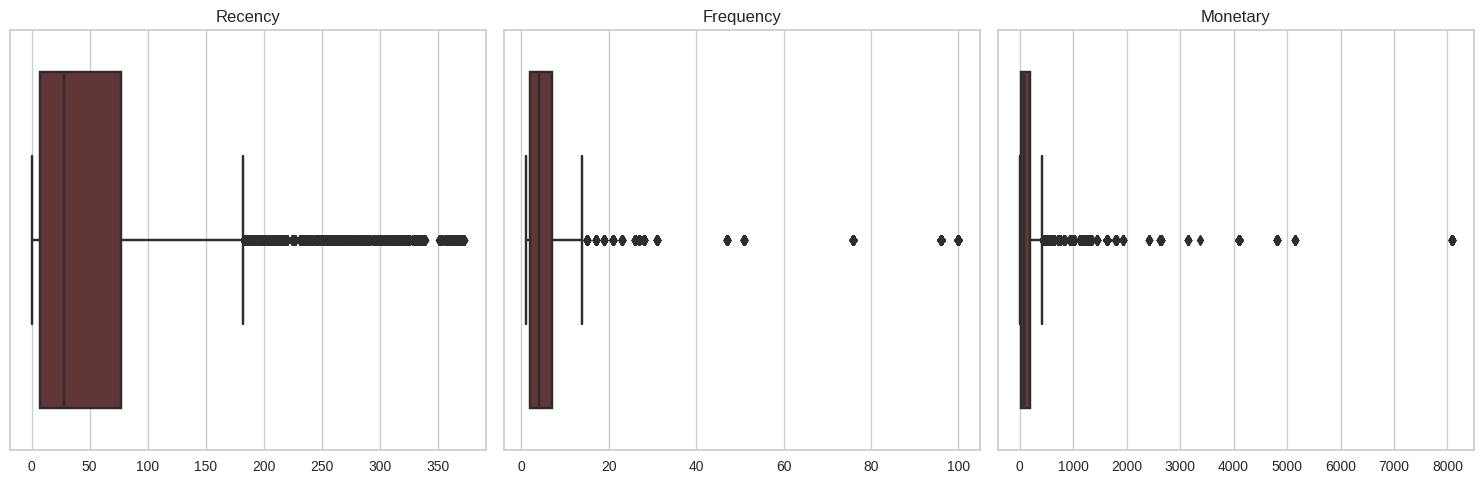

In [25]:

# Plotting box plots for each selected feature
plt.figure(figsize=(15, 5))
for i, feature in enumerate(rfm_features, start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=rfm_features[feature], color="#682F2F")
    plt.title(feature)
    plt.xlabel('')
plt.tight_layout()
plt.show()


 Removing Outliers

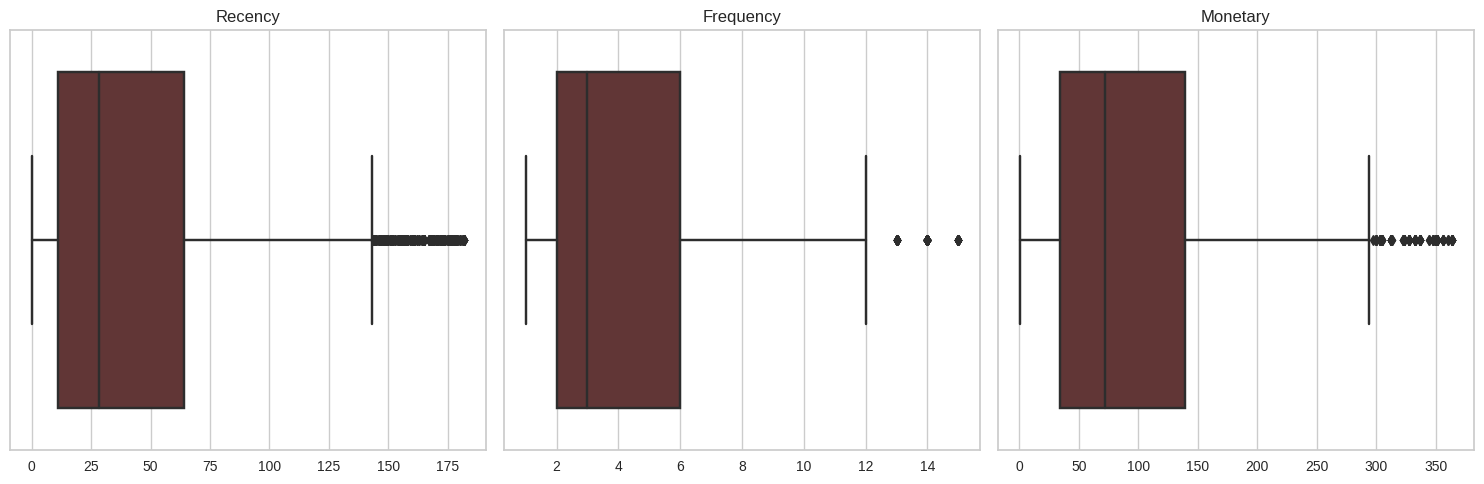

In [26]:
# Function to remove outliers based on IQR
def remove_outliers(df, features):
    df_clean = df.copy()
    for feature in features:
        Q1 = df_clean[feature].quantile(0.25)
        Q3 = df_clean[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[feature] >= lower_bound) & (df_clean[feature] <= upper_bound)]
    return df_clean

# Remove outliers from the dataset
rfm_features_clean = remove_outliers(rfm_features, rfm_features.columns)

# Plotting box plots for each selected feature with filtered dataset
plt.figure(figsize=(15, 5))
for i, feature in enumerate(rfm_features_clean, start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=rfm_features_clean[feature], color="#682F2F")
    plt.title(feature)
    plt.xlabel('')
plt.tight_layout()
plt.show()

In [27]:
# Now, rfm_features_clean contains the data without outliers
rfm_features_clean.head()

Recency  Frequency  Monetary
0       17         12    212.32
1       17         12    212.32
2       17         12    212.32
3       17         12    212.32
4       17         12    212.32

In [28]:
len(rfm_features_clean)

7922

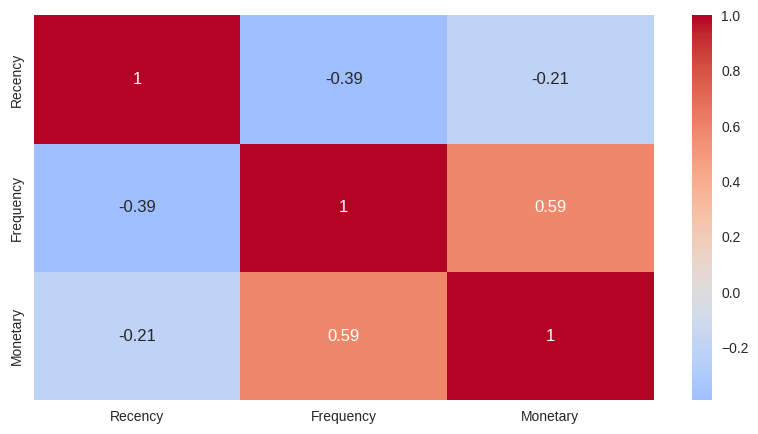

In [29]:
# Define colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Calculate the correlation matrix
corrmat = rfm_features_clean.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)
plt.show()

In [30]:
# Calculate VIF from the correlation matrix
vif_values = pd.DataFrame(np.linalg.inv(corrmat.values), index=corrmat.index, columns=corrmat.columns)

# Diagonal elements of VIF matrix represent the VIF values
vif_diagonal = vif_values.values.diagonal()

# Create a DataFrame to display VIF values
vif_df = pd.DataFrame({'Feature': corrmat.columns, 'VIF': vif_diagonal})
print(vif_df)


     Feature       VIF
0    Recency  1.183016
1  Frequency  1.723436
2   Monetary  1.523011


In [31]:
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
scaler.fit(rfm_features_clean)
scaled = pd.DataFrame(scaler.transform(rfm_features_clean), columns=rfm_features_clean.columns)
print("All numerical features are now scaled")

All numerical features are now scaled


# **Different Clustering For the best**

## **K-means Clustering**

Elbow Method to determine the number of clusters to be formed:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

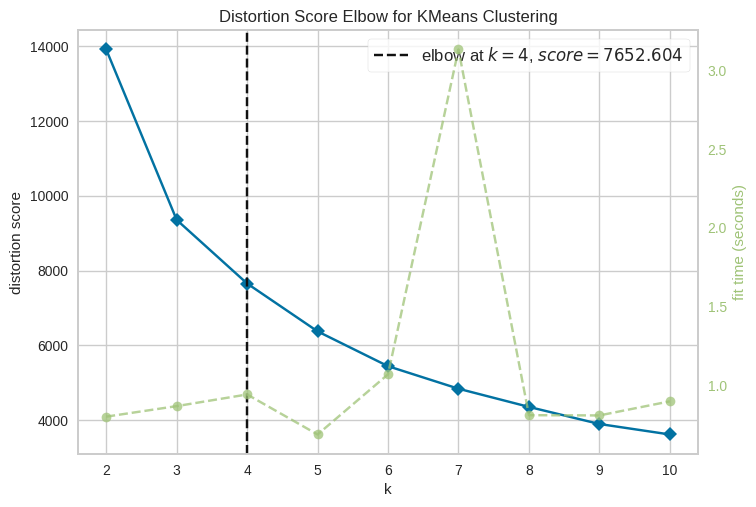

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scaled)
Elbow_M.show()

In [33]:
# Using K-means clustering for segmentation

num_clusters = 4

# Initialize KMeans object
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans clustering model to PCA-transformed data
kmeans.fit(scaled)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the original DataFrame
rfm_features_clean['K-Means_Cluster'] = cluster_labels

# Display the first few rows of the DataFrame with cluster labels
rfm_features_clean.head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency  Frequency  Monetary  K-Means_Cluster
0       17         12    212.32                3
1       17         12    212.32                3
2       17         12    212.32                3
3       17         12    212.32                3
4       17         12    212.32                3

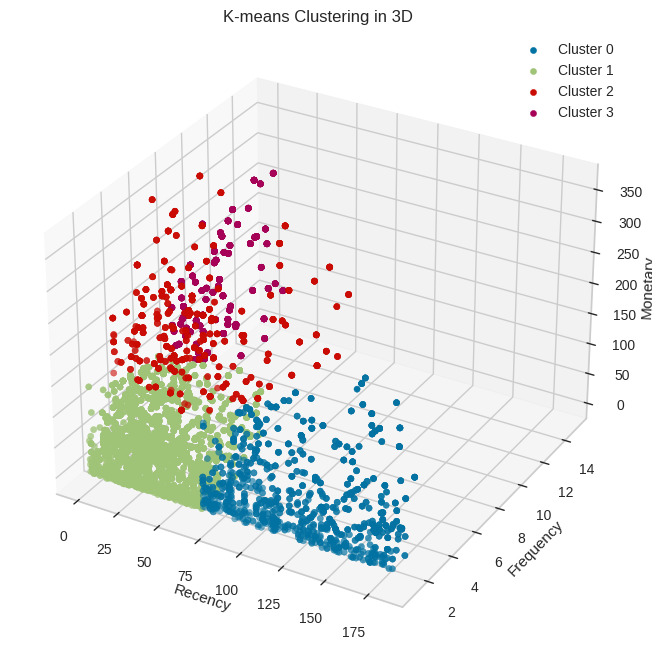

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# Initialize a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points with cluster labels
for cluster in range(num_clusters):
    ax.scatter(rfm_features_clean.loc[rfm_features_clean['K-Means_Cluster'] == cluster, 'Recency'],
               rfm_features_clean.loc[rfm_features_clean['K-Means_Cluster'] == cluster, 'Frequency'],
               rfm_features_clean.loc[rfm_features_clean['K-Means_Cluster'] == cluster, 'Monetary'],
               label=f'Cluster {cluster}')

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('K-means Clustering in 3D')

# Add legend
plt.legend()

# Show plot
plt.show()


### **silhouette score for K-means**

In [35]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)


The average silhouette_score is : 0.38169897113195833


## **Hierarchical Clustering**

In [36]:
H_data = rfm_features_clean.drop(columns=['K-Means_Cluster'])

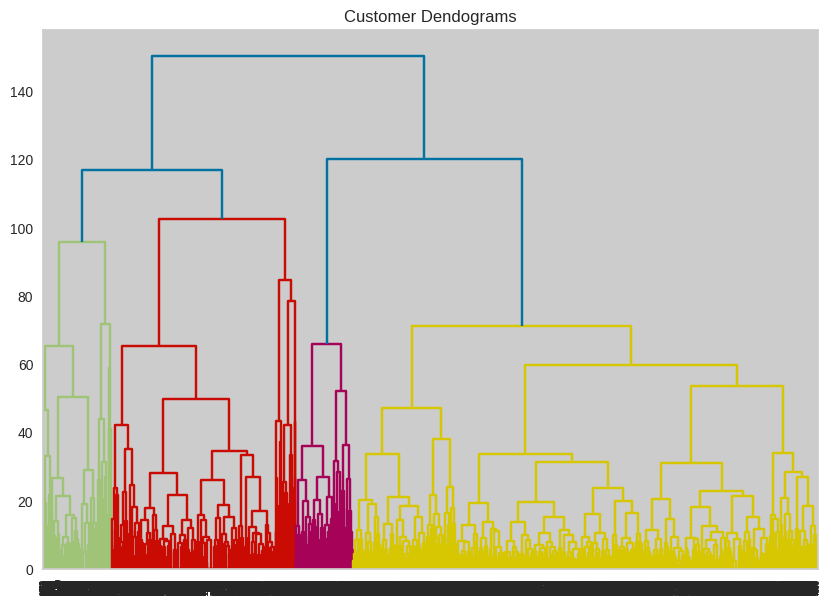

In [37]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(H_data, method='average'))


In [38]:
from sklearn.cluster import AgglomerativeClustering
Agg_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
Agg_cluster.fit_predict(H_data)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([1, 1, 1, ..., 3, 3, 3])

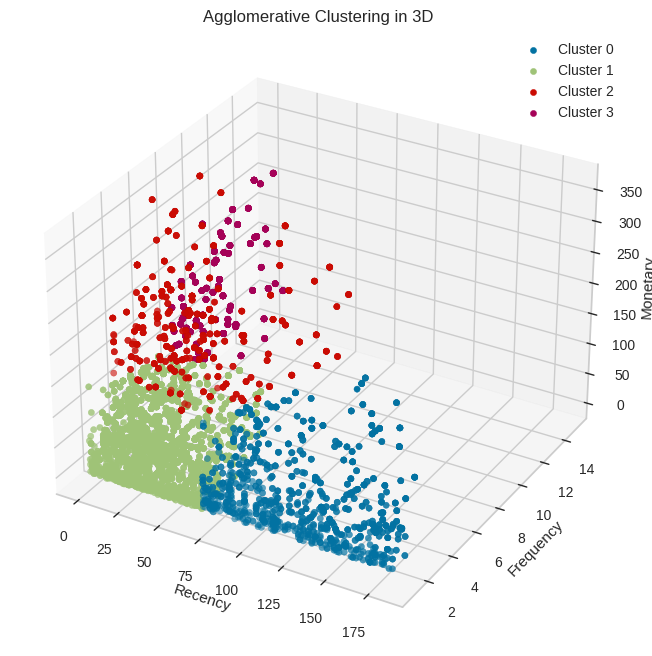

In [39]:
# Visualize in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points with cluster labels
for cluster in range(4):  # Assuming 4 clusters
    ax.scatter(H_data.iloc[cluster_labels == cluster, 0],  # Assuming the first column is X-axis
               H_data.iloc[cluster_labels == cluster, 1],  # Assuming the second column is Y-axis
               H_data.iloc[cluster_labels == cluster, 2],  # Assuming the third column is Z-axis
               label=f'Cluster {cluster}')

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Agglomerative Clustering in 3D')

# Add legend
plt.legend()

# Show plot
plt.show()

### **silhouette score**

In [40]:
# Calculate silhouette score
silhouette_avg = silhouette_score(H_data, Agg_cluster.labels_)
print("The average silhouette score is:", silhouette_avg)

The average silhouette score is: 0.4248249803059902


## **Affinity Propagation Clustering**

In [41]:
rfm_features_clean.head()

Recency  Frequency  Monetary  K-Means_Cluster
0       17         12    212.32                3
1       17         12    212.32                3
2       17         12    212.32                3
3       17         12    212.32                3
4       17         12    212.32                3

In [42]:
Aff_data = rfm_features_clean.drop(columns=['K-Means_Cluster'])
Aff_data.head()

Recency  Frequency  Monetary
0       17         12    212.32
1       17         12    212.32
2       17         12    212.32
3       17         12    212.32
4       17         12    212.32

In [43]:
from sklearn.cluster import AffinityPropagation

# Initialize Affinity Propagation clustering
affinity_propagation = AffinityPropagation()

# Fit the clustering model and predict cluster labels
affinity_propagation_labels = affinity_propagation.fit_predict(Aff_data )


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


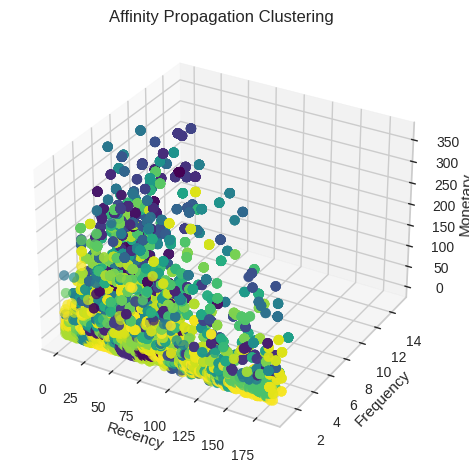

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AffinityPropagation

# Assuming Aff_data is your actual data
# Extract the values from the DataFrame if it's a pandas DataFrame
Aff_data_values = Aff_data.values if isinstance(Aff_data, pd.DataFrame) else Aff_data

# Initialize Affinity Propagation clustering
affinity_propagation = AffinityPropagation()

# Fit the clustering model and predict cluster labels
affinity_propagation_labels = affinity_propagation.fit_predict(Aff_data_values)

# Plot the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(Aff_data_values[:, 0], Aff_data_values[:, 1], Aff_data_values[:, 2], c=affinity_propagation_labels, cmap='viridis', marker='o', s=50)

ax.set_title('Affinity Propagation Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()



### silhouette_score

In [45]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(H_data, affinity_propagation_labels)
print("The average silhouette score is:", silhouette_avg)

The average silhouette score is: 0.05346874991303184


## **Mean Shift clustering**

In [46]:
rfm_features_clean.head()

Recency  Frequency  Monetary  K-Means_Cluster
0       17         12    212.32                3
1       17         12    212.32                3
2       17         12    212.32                3
3       17         12    212.32                3
4       17         12    212.32                3

In [47]:
Mean_data = rfm_features_clean.drop(columns=['K-Means_Cluster'])
Mean_data.head()

Recency  Frequency  Monetary
0       17         12    212.32
1       17         12    212.32
2       17         12    212.32
3       17         12    212.32
4       17         12    212.32

In [48]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform Mean Shift clustering
mean_shift_cluster = MeanShift()
cluster_labels = mean_shift_cluster.fit_predict(Mean_data)


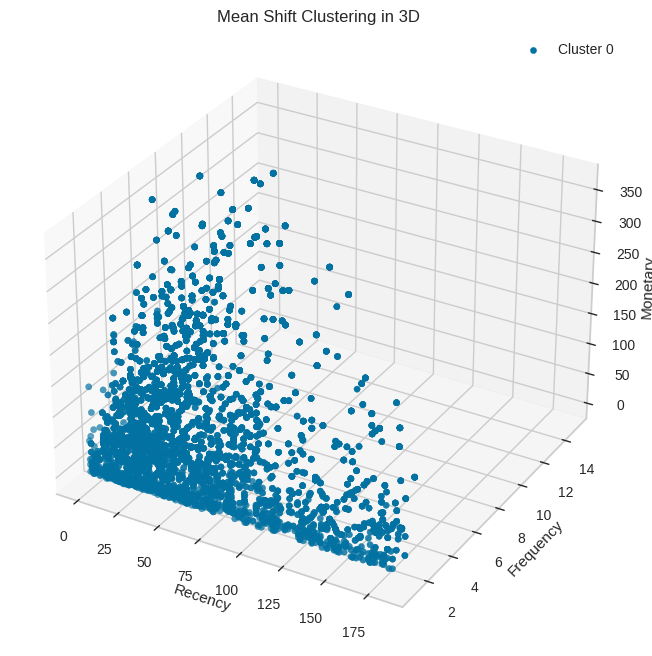

In [49]:
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming Mean_data is your data
# Convert Mean_data to numpy array if it's a Pandas DataFrame
if isinstance(Mean_data, pd.DataFrame):
    Mean_data = Mean_data.values

# Perform Mean Shift clustering
mean_shift_cluster = MeanShift()
cluster_labels = mean_shift_cluster.fit_predict(Mean_data)

# Plotting the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in np.unique(cluster_labels):
    cluster_points = Mean_data[cluster_labels == cluster_label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_label}')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Mean Shift Clustering in 3D')
ax.legend()
plt.show()

### silhouette score

* score willnt work since it has only one cluster. If it had 2 or more then the code below would be used.



silhouette_avg = silhouette_score(Mean_data, cluster_labels)
print(f"The silhouette score is: {silhouette_avg}")

## **HDBSCAN**    

In [50]:
rfm_features_clean.head()

Recency  Frequency  Monetary  K-Means_Cluster
0       17         12    212.32                3
1       17         12    212.32                3
2       17         12    212.32                3
3       17         12    212.32                3
4       17         12    212.32                3

In [51]:
HD_data = rfm_features_clean.drop(columns=['K-Means_Cluster'])
HD_data.head()

Recency  Frequency  Monetary
0       17         12    212.32
1       17         12    212.32
2       17         12    212.32
3       17         12    212.32
4       17         12    212.32

In [52]:
import hdbscan
from sklearn.metrics import silhouette_score

# Perform HDBSCAN clustering
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=150)
cluster_labels_hdbscan = hdbscan_cluster.fit_predict(HD_data)

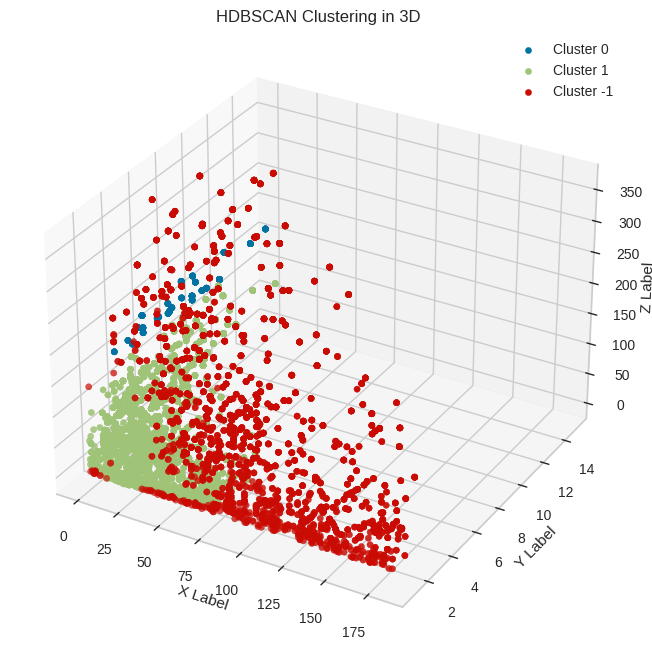

In [53]:
# Plotting the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in set(cluster_labels_hdbscan):
    cluster_points = HD_data[cluster_labels_hdbscan == cluster_label]
    ax.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], cluster_points.iloc[:, 2], label=f'Cluster {cluster_label}')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('HDBSCAN Clustering in 3D')
ax.legend()
plt.show()

### silhouette score

In [54]:
# Calculate silhouette score
silhouette_avg_hdbscan = silhouette_score(HD_data, cluster_labels_hdbscan)
print(f"The silhouette score for HDBSCAN is: {silhouette_avg_hdbscan}")

The silhouette score for HDBSCAN is: 0.11109964652621768


# **Evaluating the best Model (Hierarchical)**

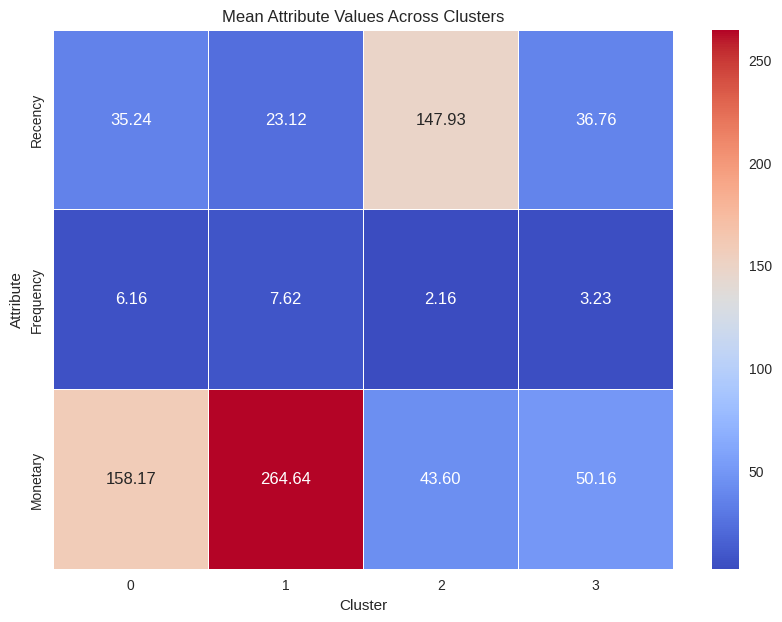

In [55]:
import seaborn as sns

# Calculate the mean values of each attribute within each cluster
cluster_means = H_data.copy()  # Make a copy of the data
cluster_means['Cluster'] = Agg_cluster.labels_  # Add cluster labels to the data
cluster_means = cluster_means.groupby('Cluster').mean()  # Calculate mean values for each cluster

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cluster_means.T, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Mean Attribute Values Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Attribute')
plt.show()


In [68]:
# Assign cluster labels to each data point
H_data['Cluster'] = Agg_cluster.labels_

# Calculate RFM scores for each data point within each cluster
cluster_rfm_scores = H_data.groupby('Cluster').agg({
    'Recency': 'mean',  # You can use mean or any other aggregation function based on your requirements
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Now, you can calculate RFM scores for each cluster
# You can use the quartile method as shown in the previous example or any other method that suits your business needs

# Assuming you're using quartiles to calculate RFM scores
cluster_rfm_scores['R_score'] = pd.qcut(cluster_rfm_scores['Recency'], q=4, labels=False) + 1
cluster_rfm_scores['F_score'] = pd.qcut(cluster_rfm_scores['Frequency'], q=4, labels=False) + 1
cluster_rfm_scores['M_score'] = pd.qcut(cluster_rfm_scores['Monetary'], q=4, labels=False) + 1

# Calculate RFM score for each cluster
cluster_rfm_scores['RFM_score'] = cluster_rfm_scores['R_score'] + cluster_rfm_scores['F_score'] + cluster_rfm_scores['M_score']

# Display the RFM scores for each cluster
cluster_rfm_scores


Cluster     Recency  Frequency    Monetary  R_score  F_score  M_score  \
0        0   35.243100   6.162951  158.167442        2        3        3   
1        1   23.117310   7.619456  264.642532        1        4        4   
2        2  147.931973   2.161565   43.598963        4        1        1   
3        3   36.757314   3.230057   50.158945        3        2        2   

   RFM_score  
0          8  
1          9  
2          6  
3          7

In [69]:
# Define function to assign customer segments based on RFM scores for each cluster
def assign_cluster_segment(row):
    if row['RFM_score'] >= 9:
        return 'High-Value Customers'
    elif row['RFM_score'] >= 8:
        return 'Potential Loyalists'
    elif row['RFM_score'] >= 7:
        return 'New Customers'
    elif row['RFM_score'] >= 6:
        return 'At-Risk Customers'
    elif row['RFM_score'] >= 5:
        return 'Lost Customers'
    else:
        return 'Low-Value Customers'

# Apply the function to assign segments to each cluster
cluster_rfm_scores['Segment'] = cluster_rfm_scores.apply(assign_cluster_segment, axis=1)

# Display the dataset with assigned segments for each cluster
cluster_rfm_scores



Cluster     Recency  Frequency    Monetary  R_score  F_score  M_score  \
0        0   35.243100   6.162951  158.167442        2        3        3   
1        1   23.117310   7.619456  264.642532        1        4        4   
2        2  147.931973   2.161565   43.598963        4        1        1   
3        3   36.757314   3.230057   50.158945        3        2        2   

   RFM_score               Segment  
0          8   Potential Loyalists  
1          9  High-Value Customers  
2          6     At-Risk Customers  
3          7         New Customers

In [70]:
# Count the number of data points in each cluster (that is the number of customers)
cluster_counts = H_data['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

# Display the count of data points in each cluster
print(cluster_counts)


   Cluster  Count
0        3   4751
1        0   1884
2        1    699
3        2    588


In [71]:
!pip install squarify


In [72]:
import matplotlib.pyplot as plt
import squarify

# Count the number of data points in each cluster
cluster_counts = H_data['Cluster'].value_counts(normalize=True).reset_index()
cluster_counts.columns = ['Cluster', 'Customer Percentage']

# Merge with cluster_rfm_scores to get other information
cluster_rfm_scores = cluster_rfm_scores.merge(cluster_counts, on='Cluster')

# Define labels for segments
labels = [f"{segment}\nCluster: {cluster}\nMonetary: {monetary:.2f}\nRecency: {recency}\nFrequency: {frequency}\nRFM Score: {rfm_score}\nCustomer Percentage: {customer_percentage:.2%}"
          for segment, cluster, monetary, recency, frequency, rfm_score, customer_percentage
          in zip(cluster_rfm_scores['Segment'], cluster_rfm_scores['Cluster'],
                 cluster_rfm_scores['Monetary'], cluster_rfm_scores['Recency'],
                 cluster_rfm_scores['Frequency'], cluster_rfm_scores['RFM_score'],
                 cluster_rfm_scores['Customer Percentage'])]

# Define sizes for each segment based on RFM score
sizes = cluster_rfm_scores['RFM_score']

# Create colors for each segment
colors = plt.cm.tab10(range(len(labels)))

# Plot treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.7, text_kwargs={'fontsize': 10})
plt.title("RFM Segmentation Treemap")
plt.axis('off')
plt.show()
